# Transfer Learning con EfficientNetV2-S - Versión 1 (V1)

Proyecto de clasificación de frutas y verduras usando Transfer Learning con EfficientNetV2-S.

**Características de la Versión 1:**
- Modelo base: EfficientNetV2-S preentrenado
- Clasificador simple: una sola capa Fully Connected
- Sin Batch Normalization adicional
- Sin Dropout
- Sin capas ocultas adicionales
- Early stopping basado en validation loss

## SECCION 1 - Imports y Configuracion

Importacion de librerias necesarias y configuracion del dispositivo (GPU/CPU)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
import copy
import warnings
warnings.filterwarnings('ignore')

# Configuracion del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo utilizado: {device}')

# Configuracion para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Dispositivo utilizado: cuda


## SECCION 2 - Funciones Reutilizables

Funciones modulares para crear transformaciones, cargar datos, entrenar y evaluar el modelo

In [28]:
def create_transforms(img_size=224):
    """
    Crea las transformaciones para entrenamiento y validacion/test
    
    Args:
        img_size (int): Tamaño de imagen (default: 224)
    
    Returns:
        tuple: (train_transform, val_test_transform)
    """
    # Normalizacion de ImageNet
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    
    # Transformaciones para entrenamiento (con data augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    
    # Transformaciones para validacion y test (sin augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    
    return train_transform, val_test_transform


def load_datasets(data_dir, train_transform, val_test_transform):
    """
    Carga los datasets desde la estructura de directorios
    
    Args:
        data_dir (str): Directorio raiz de los datos
        train_transform: Transformaciones para entrenamiento
        val_test_transform: Transformaciones para validacion/test
    
    Returns:
        tuple: (train_dataset, val_dataset, test_dataset)
    """
    train_dataset = datasets.ImageFolder(
        root=f"{data_dir}/train",
        transform=train_transform
    )
    
    val_dataset = datasets.ImageFolder(
        root=f"{data_dir}/validation", 
        transform=val_test_transform
    )
    
    test_dataset = datasets.ImageFolder(
        root=f"{data_dir}/test",
        transform=val_test_transform
    )
    
    return train_dataset, val_dataset, test_dataset


def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    """
    Crea los DataLoaders para entrenamiento, validacion y test
    
    Args:
        train_dataset: Dataset de entrenamiento
        val_dataset: Dataset de validacion
        test_dataset: Dataset de test
        batch_size (int): Tamaño del batch
    
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [ ]:
def evaluate_model(model, test_loader, class_names, device='cpu'):
    """
    Evalua el modelo en el conjunto de test
    
    Args:
        model: Modelo entrenado
        test_loader: DataLoader de test
        class_names (list): Nombres de las clases
        device (str): Dispositivo de computo
    
    Returns:
        tuple: (accuracy, y_true, y_pred)
    """
    model = model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    total_samples = 0
    correct_predictions = 0
    
    print("Evaluando modelo en conjunto de test...")
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    accuracy = correct_predictions / total_samples
    
    print(f"\nResultados de evaluacion:")
    print(f"Accuracy total: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Muestras correctas: {correct_predictions}/{total_samples}")
    
    # Matriz de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusion - EfficientNetV2-S V1', fontsize=16, fontweight='bold')
    plt.xlabel('Prediccion', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificacion
    print("\nReporte de Clasificacion:")
    print("-" * 60)
    report = classification_report(y_true, y_pred, target_names=class_names, 
                                 digits=4, output_dict=False)
    print(report)
    
    return accuracy, y_true, y_pred

## SECCION 3 - Aplicacion Concreta

Implementacion del proyecto V1 usando las funciones creadas

### 3.1 - Configuracion y Carga de Datos

In [30]:
# Configuracion del proyecto
data_dir = "datos"
img_size = 224
batch_size = 32

# Crear transformaciones
print("Creando transformaciones...")
train_transform, val_test_transform = create_transforms(img_size=img_size)

# Cargar datasets
print("Cargando datasets...")
train_dataset, val_dataset, test_dataset = load_datasets(
    data_dir, train_transform, val_test_transform
)

# Mostrar informacion de las clases
print(f"\nClases detectadas: {train_dataset.classes}")
print(f"Numero de clases: {len(train_dataset.classes)}")
print(f"Muestras de entrenamiento: {len(train_dataset)}")
print(f"Muestras de validacion: {len(val_dataset)}")
print(f"Muestras de test: {len(test_dataset)}")

# Crear DataLoaders
print("\nCreando DataLoaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=batch_size
)

print(f"Batches de entrenamiento: {len(train_loader)}")
print(f"Batches de validacion: {len(val_loader)}")
print(f"Batches de test: {len(test_loader)}")

# Guardar variables importantes
class_names = train_dataset.classes
num_classes = len(class_names)

Creando transformaciones...
Cargando datasets...

Clases detectadas: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Numero de clases: 5
Muestras de entrenamiento: 438
Muestras de validacion: 47
Muestras de test: 50

Creando DataLoaders...
Batches de entrenamiento: 14
Batches de validacion: 2
Batches de test: 2


In [31]:
def build_model_v1(num_classes):
    """
    Construye el modelo EfficientNetV2-S V1 con transfer learning
    
    Args:
        num_classes (int): Numero de clases para el clasificador
    
    Returns:
        model: Modelo EfficientNetV2-S modificado para V1
    """
    # Cargar modelo preentrenado
    model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
    
    # Congelar todas las capas del feature extractor
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Obtener el numero de features de entrada del clasificador
    in_features = model.classifier[1].in_features
    
    # Reemplazar el clasificador con una sola capa Linear (V1)
    # Sin BatchNorm, sin Dropout, sin capas ocultas adicionales
    model.classifier = nn.Linear(in_features, num_classes)
    
    print(f"Modelo EfficientNetV2-S V1 creado exitosamente")
    print(f"Features de entrada del clasificador: {in_features}")
    print(f"Clases de salida: {num_classes}")
    print(f"Arquitectura V1: Una sola capa Linear({in_features} -> {num_classes})")
    
    return model


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    """
    Entrena el modelo con early stopping y tracking de accuracy
    
    Returns:
        tuple: (best_model, train_losses, val_losses, train_accuracies, val_accuracies, best_epoch)
    """
    model = model.to(device)
    
    # Variables para tracking
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    best_epoch = 0
    
    print(f"Iniciando entrenamiento...")
    print(f"Device: {device}")
    print(f"Epochs maximos: {num_epochs}")
    print(f"Early stopping patience: {patience}")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Fase de entrenamiento
        model.train()
        running_loss = 0.0
        train_samples = 0
        train_correct = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Estadisticas
            running_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)
            
            # Calcular accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            
            if (batch_idx + 1) % 10 == 0:
                current_acc = 100.0 * train_correct / train_samples
                print(f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx+1}/{len(train_loader)} - "
                      f"Loss: {loss.item():.4f} - Acc: {current_acc:.2f}%")
        
        # Métricas de entrenamiento
        epoch_train_loss = running_loss / train_samples
        epoch_train_accuracy = 100.0 * train_correct / train_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        
        # Fase de validación
        model.eval()
        val_running_loss = 0.0
        val_samples = 0
        val_correct = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
        
        # Métricas de validación
        epoch_val_loss = val_running_loss / val_samples
        epoch_val_accuracy = 100.0 * val_correct / val_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch+1}/{num_epochs} completado en {epoch_time:.2f}s")
        print(f"Train - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_accuracy:.2f}%")
        print(f"Val   - Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_accuracy:.2f}%")
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch + 1
            print(f"🌟 Nuevo mejor modelo! Val Loss: {best_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")
        else:
            patience_counter += 1
            print(f"Sin mejora. Paciencia: {patience_counter}/{patience}")
        
        print("-" * 60)
        
        if patience_counter >= patience:
            print(f"Early stopping activado! Sin mejora por {patience} epochs consecutivos.")
            break
    
    model.load_state_dict(best_model_state)
    total_time = time.time() - start_time
    
    print(f"\n🎉 Entrenamiento completado!")
    print(f"Tiempo total: {total_time/60:.2f} minutos")
    print(f"Mejor epoch: {best_epoch}")
    print(f"Mejor validation loss: {best_val_loss:.4f}")
    print(f"Best validation accuracy: {val_accuracies[best_epoch-1]:.2f}%")
    print(f"Total de epochs: {len(train_losses)}")
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies, best_epoch


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, best_epoch=None):
    """
    Grafica las curvas de perdida y accuracy de entrenamiento y validacion
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Crear figura con subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # SUBPLOT 1: LOSS
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    
    if best_epoch:
        ax1.axvline(x=best_epoch, color='green', linestyle='--', 
                   label=f'Best Epoch ({best_epoch})', alpha=0.7, linewidth=2)
    
    ax1.set_title('Curvas de Pérdida - EfficientNetV2-S V1', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # SUBPLOT 2: ACCURACY
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, val_accuracies, 'orange', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    
    if best_epoch:
        ax2.axvline(x=best_epoch, color='green', linestyle='--', 
                   label=f'Best Epoch ({best_epoch})', alpha=0.7, linewidth=2)
    
    ax2.set_title('Curvas de Precisión - EfficientNetV2-S V1', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    print("📊 RESUMEN DE MÉTRICAS:")
    print("="*60)
    print(f"📈 LOSS:")
    print(f"  • Final training loss:     {train_losses[-1]:.4f}")
    print(f"  • Final validation loss:   {val_losses[-1]:.4f}")
    print(f"  • Best validation loss:    {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")
    print(f"📊 ACCURACY:")
    print(f"  • Final training accuracy:     {train_accuracies[-1]:.2f}%")
    print(f"  • Final validation accuracy:   {val_accuracies[-1]:.2f}%")
    print(f"  • Best validation accuracy:    {max(val_accuracies):.2f}% (epoch {val_accuracies.index(max(val_accuracies)) + 1})")
    
    if best_epoch:
        print(f"⭐ MEJOR MODELO (Epoch {best_epoch}):")
        print(f"  • Validation loss:     {val_losses[best_epoch-1]:.4f}")
        print(f"  • Validation accuracy: {val_accuracies[best_epoch-1]:.2f}%")
    print("="*60)

In [32]:
# Construir modelo V1
print("Construyendo modelo EfficientNetV2-S V1...")
model = build_model_v1(num_classes)
model = model.to(device)

# Mostrar arquitectura del clasificador
print(f"\nArquitectura del clasificador:")
print(model.classifier)

# Verificar parametros entrenables
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\nParametros totales: {total_params:,}")
print(f"Parametros entrenables: {trainable_params:,}")
print(f"Parametros congelados: {total_params - trainable_params:,}")
print(f"Porcentaje entrenables: {(trainable_params/total_params)*100:.2f}%")

# Configurar criterion y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nConfiguración del entrenamiento:")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Early stopping: activado (patience=5)")

Construyendo modelo EfficientNetV2-S V1...
Modelo EfficientNetV2-S V1 creado exitosamente
Features de entrada del clasificador: 1280
Clases de salida: 5
Arquitectura V1: Una sola capa Linear(1280 -> 5)

Arquitectura del clasificador:
Linear(in_features=1280, out_features=5, bias=True)

Parametros totales: 20,183,893
Parametros entrenables: 6,405
Parametros congelados: 20,177,488
Porcentaje entrenables: 0.03%

Configuración del entrenamiento:
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Early stopping: activado (patience=5)


### 3.3 - Entrenamiento con Early Stopping

In [33]:
# Entrenar el modelo
num_epochs = 25
patience = 5

print("="*60)
print("ENTRENAMIENTO DEL MODELO EFFICIENTNETV2-S V1")
print("="*60)

trained_model, train_losses, val_losses, train_accuracies, val_accuracies, best_epoch = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

print("\n" + "="*60)
print("ENTRENAMIENTO COMPLETADO")
print("="*60)

ENTRENAMIENTO DEL MODELO EFFICIENTNETV2-S V1
Iniciando entrenamiento...
Device: cuda
Epochs maximos: 25
Early stopping patience: 5
------------------------------------------------------------
Epoch 1/25 - Batch 10/14 - Loss: 1.2480 - Acc: 42.81%
Epoch 1/25 completado en 9.74s
Train - Loss: 1.3618, Acc: 51.83%
Val   - Loss: 1.0713, Acc: 80.85%
🌟 Nuevo mejor modelo! Val Loss: 1.0713, Val Acc: 80.85%
------------------------------------------------------------
Epoch 2/25 - Batch 10/14 - Loss: 0.9767 - Acc: 83.44%
Epoch 2/25 completado en 9.77s
Train - Loss: 0.8626, Acc: 84.02%
Val   - Loss: 0.6211, Acc: 89.36%
🌟 Nuevo mejor modelo! Val Loss: 0.6211, Val Acc: 89.36%
------------------------------------------------------------
Epoch 3/25 - Batch 10/14 - Loss: 0.6519 - Acc: 88.44%
Epoch 3/25 completado en 9.78s
Train - Loss: 0.6230, Acc: 88.36%
Val   - Loss: 0.4511, Acc: 93.62%
🌟 Nuevo mejor modelo! Val Loss: 0.4511, Val Acc: 93.62%
-----------------------------------------------------------

### 3.4 - Visualizacion de Curvas de Perdida

Generando gráficas de métricas de entrenamiento...


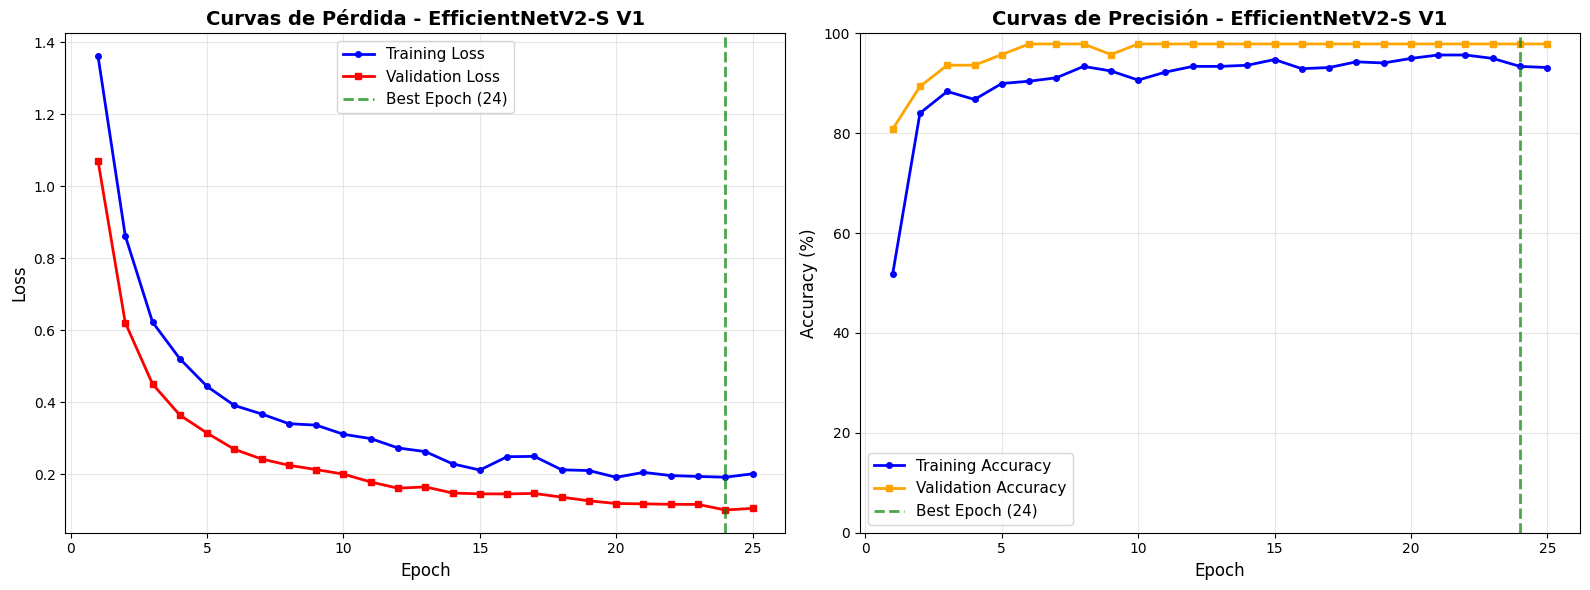

📊 RESUMEN DE MÉTRICAS:
📈 LOSS:
  • Final training loss:     0.2018
  • Final validation loss:   0.1059
  • Best validation loss:    0.1013 (epoch 24)
📊 ACCURACY:
  • Final training accuracy:     93.15%
  • Final validation accuracy:   97.87%
  • Best validation accuracy:    97.87% (epoch 6)
⭐ MEJOR MODELO (Epoch 24):
  • Validation loss:     0.1013
  • Validation accuracy: 97.87%


In [34]:
# Graficar curvas de perdida
print("Generando gráficas de métricas de entrenamiento...")
plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, best_epoch)

### 3.5 - Evaluacion Final en Conjunto de Test

EVALUACION FINAL EN CONJUNTO DE TEST
Evaluando modelo en conjunto de test...

Resultados de evaluacion:
Accuracy total: 0.9800 (98.00%)
Muestras correctas: 49/50


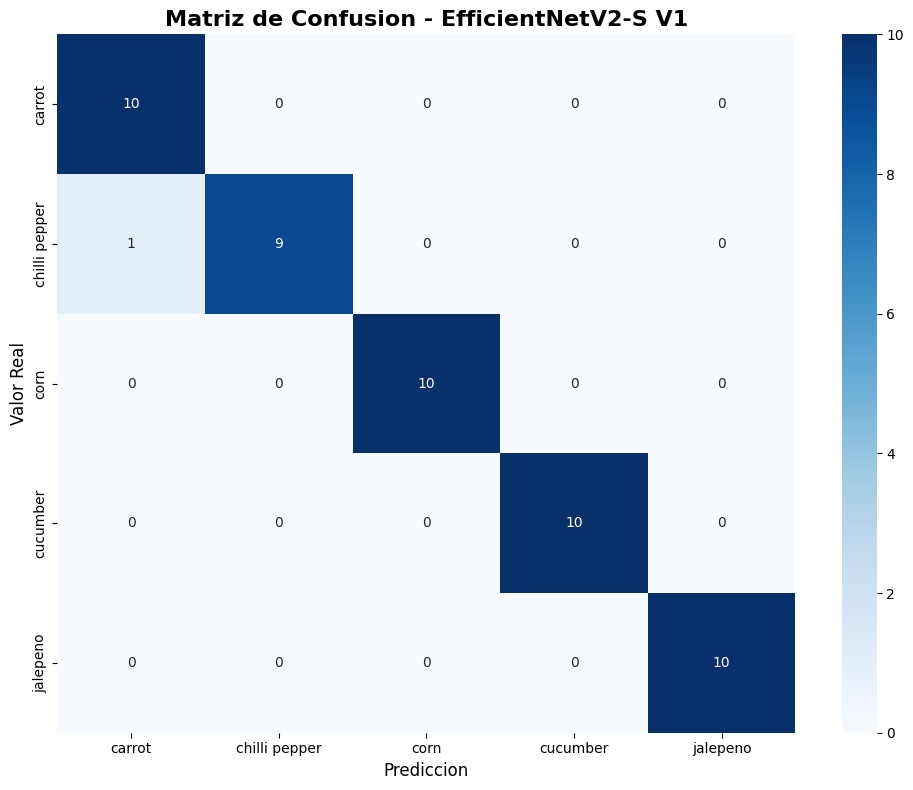


Reporte de Clasificacion:
------------------------------------------------------------
               precision    recall  f1-score   support

       carrot     0.9091    1.0000    0.9524        10
chilli pepper     1.0000    0.9000    0.9474        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10
     jalepeno     1.0000    1.0000    1.0000        10

     accuracy                         0.9800        50
    macro avg     0.9818    0.9800    0.9799        50
 weighted avg     0.9818    0.9800    0.9799        50



In [35]:
# Evaluacion completa del modelo
print("="*60)
print("EVALUACION FINAL EN CONJUNTO DE TEST")
print("="*60)

test_accuracy, y_true, y_pred = evaluate_model(
    model=trained_model,
    test_loader=test_loader,
    class_names=class_names,
    device=device
)

### 3.6 - Guardado del Modelo Entrenado

In [36]:
# Guardar el modelo entrenado
model_save_path = "efficientnetv2_s_v1.pth"

torch.save({
    'epoch': best_epoch,
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_accuracy': test_accuracy,
    'class_names': class_names,
    'num_classes': num_classes
}, model_save_path)

print(f"Modelo guardado exitosamente en: {model_save_path}")
print(f"Accuracy final en test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n" + "="*60)
print("PROYECTO COMPLETADO - EFFICIENTNETV2-S V1")
print("="*60)
print(f"Mejor epoch: {best_epoch}")
print(f"Mejor validation loss: {min(val_losses):.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Clases: {class_names}")
print("="*60)

Modelo guardado exitosamente en: efficientnetv2_s_v1.pth
Accuracy final en test: 0.9800 (98.00%)

PROYECTO COMPLETADO - EFFICIENTNETV2-S V1
Mejor epoch: 24
Mejor validation loss: 0.1013
Test accuracy: 0.9800
Clases: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']


### 3.7 - Funciones para Prediccion de Imagenes Individuales

In [37]:
import torch.nn.functional as F
from PIL import Image
import os
import random

def predict_single_image(model, image_path, class_names, transform, device):
    """
    Predice la clase de una imagen individual
    
    Args:
        model: Modelo entrenado
        image_path: Ruta a la imagen
        class_names: Lista de nombres de las clases
        transform: Transformaciones a aplicar
        device: Dispositivo de computo
    
    Returns:
        tuple: (predictions, predicted_class, confidence, original_image)
    """
    try:
        # Cargar y procesar la imagen
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        
        # Aplicar transformaciones
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Realizar prediccion
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = F.softmax(outputs, dim=1)
            
            # Obtener todas las probabilidades
            probs = probabilities.cpu().numpy()[0]
            
            # Crear lista de predicciones ordenadas
            predictions = [(class_names[i], prob * 100) for i, prob in enumerate(probs)]
            predictions.sort(key=lambda x: x[1], reverse=True)
            
            # Clase con mayor probabilidad
            predicted_class = predictions[0][0]
            confidence = predictions[0][1]
        
        return predictions, predicted_class, confidence, original_image
    
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return None, None, None, None


def visualize_prediction_result(image, predictions, predicted_class, image_path, top_k=5):
    """
    Visualiza la imagen y las predicciones
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Mostrar imagen original
    ax1.imshow(image)
    ax1.set_title(f'Imagen: {os.path.basename(image_path)}\nPrediccion: {predicted_class}', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Mostrar grafico de barras con probabilidades
    top_predictions = predictions[:top_k]
    classes = [pred[0] for pred in top_predictions]
    probs = [pred[1] for pred in top_predictions]
    
    # Colores para las barras
    colors = ['#2E86AB' if i == 0 else '#A23B72' for i in range(len(classes))]
    
    bars = ax2.barh(range(len(classes)), probs, color=colors, alpha=0.8)
    ax2.set_yticks(range(len(classes)))
    ax2.set_yticklabels(classes, fontsize=12)
    ax2.set_xlabel('Probabilidad (%)', fontsize=12)
    ax2.set_title(f'Top {len(top_predictions)} Predicciones', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Agregar valores en las barras
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        ax2.text(prob + 1, bar.get_y() + bar.get_height()/2, 
                f'{prob:.1f}%', va='center', ha='left',
                fontweight='bold' if i == 0 else 'normal')
    
    plt.tight_layout()
    plt.show()


def print_detailed_prediction(predictions, image_path, top_k=5):
    """
    Imprime resumen detallado de las predicciones
    """
    print("\n" + "="*70)
    print(f"PREDICCION PARA: {os.path.basename(image_path)}")
    print("="*70)
    
    display_predictions = predictions[:top_k]
    for i, (class_name, probability) in enumerate(display_predictions):
        status = "⭐ PREDICCION PRINCIPAL" if i == 0 else ""
        print(f"{i+1:2d}. {class_name:<15} {probability:6.2f}% {status}")
    
    print("="*70)


def predict_random_from_test(model, test_dataset_path, class_names, transform, device, num_samples=3):
    """
    Selecciona imagenes aleatorias del conjunto de test y realiza predicciones
    """
    # Obtener todas las clases disponibles
    available_classes = [d for d in os.listdir(test_dataset_path) 
                        if os.path.isdir(os.path.join(test_dataset_path, d))]
    
    print(f"Clases disponibles en test: {available_classes}")
    
    # Seleccionar imagenes aleatorias
    selected_images = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    for class_folder in available_classes:
        class_path = os.path.join(test_dataset_path, class_folder)
        images = [f for f in os.listdir(class_path) 
                 if os.path.splitext(f.lower())[1] in valid_extensions]
        
        if images:
            # Seleccionar una imagen aleatoria de esta clase
            selected_image = random.choice(images)
            selected_images.append(os.path.join(class_path, selected_image))
    
    # Limitar al numero de muestras solicitado
    selected_images = selected_images[:num_samples]
    
    print(f"\nAnalizando {len(selected_images)} imagenes aleatorias del conjunto de test...")
    
    # Procesar cada imagen
    for i, image_path in enumerate(selected_images):
        print(f"\n{'='*25} IMAGEN {i+1}/{len(selected_images)} {'='*25}")
        
        predictions, predicted_class, confidence, original_image = predict_single_image(
            model, image_path, class_names, transform, device
        )
        
        if predictions:
            # Obtener la clase real del path
            real_class = os.path.basename(os.path.dirname(image_path))
            
            print(f"Clase real: {real_class}")
            print(f"Prediccion: {predicted_class} (Confianza: {confidence:.2f}%)")
            
            # Verificar si la prediccion es correcta
            is_correct = "✅ CORRECTA" if predicted_class == real_class else "❌ INCORRECTA"
            print(f"Resultado: {is_correct}")
            
            visualize_prediction_result(original_image, predictions, predicted_class, image_path, top_k=len(class_names))
            print_detailed_prediction(predictions, image_path, top_k=len(class_names))
        else:
            print(f"Error al procesar: {image_path}")

### 3.8 - Seccion Interactiva de Prediccion

In [38]:
# Seccion interactiva para probar el modelo entrenado

print("="*70)
print("SECCION DE PREDICCION DE IMAGENES INDIVIDUALES")
print("="*70)
print("El modelo ha sido entrenado y esta listo para realizar predicciones")
print(f"Clases disponibles: {class_names}")
print(f"Accuracy del modelo en test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*70)

SECCION DE PREDICCION DE IMAGENES INDIVIDUALES
El modelo ha sido entrenado y esta listo para realizar predicciones
Clases disponibles: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Accuracy del modelo en test: 0.9800 (98.00%)



🎲 OPCION 1: Predicciones en imagenes aleatorias del conjunto de test
----------------------------------------------------------------------
Clases disponibles en test: ['corn', 'cucumber', 'jalepeno', 'carrot', 'chilli pepper']

Analizando 3 imagenes aleatorias del conjunto de test...

========================= IMAGEN 1/3 =========================
Clase real: corn
Prediccion: corn (Confianza: 99.92%)
Resultado: ✅ CORRECTA


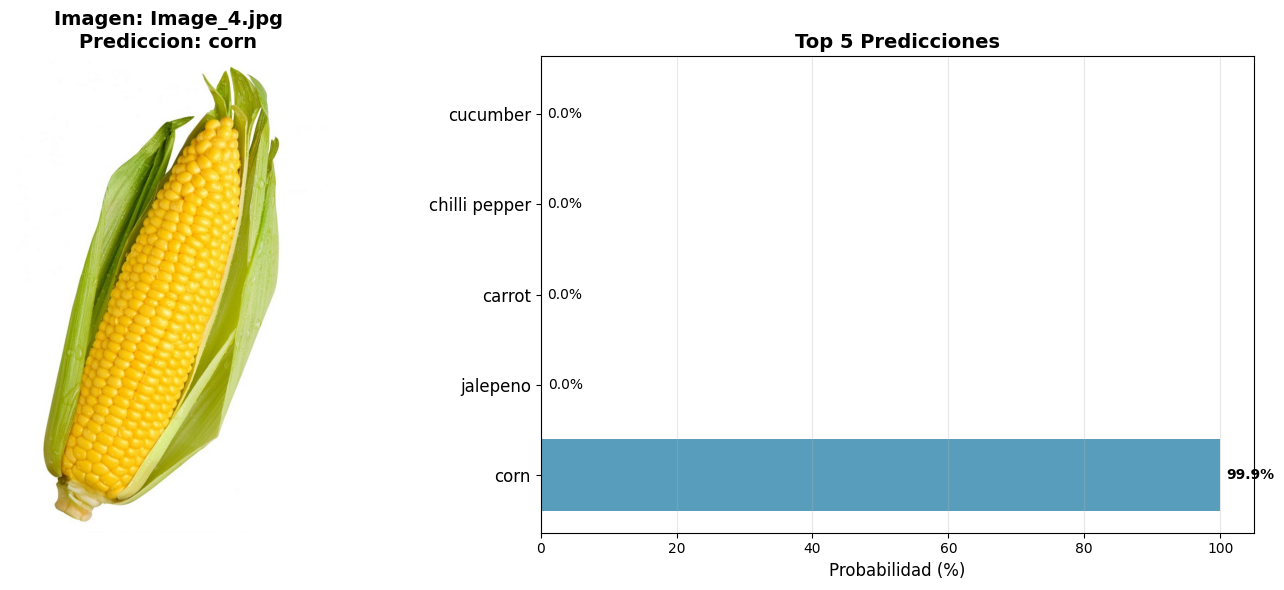


PREDICCION PARA: Image_4.jpg
 1. corn             99.92% ⭐ PREDICCION PRINCIPAL
 2. jalepeno          0.04% 
 3. carrot            0.02% 
 4. chilli pepper     0.01% 
 5. cucumber          0.01% 

========================= IMAGEN 2/3 =========================
Clase real: cucumber
Prediccion: cucumber (Confianza: 98.05%)
Resultado: ✅ CORRECTA


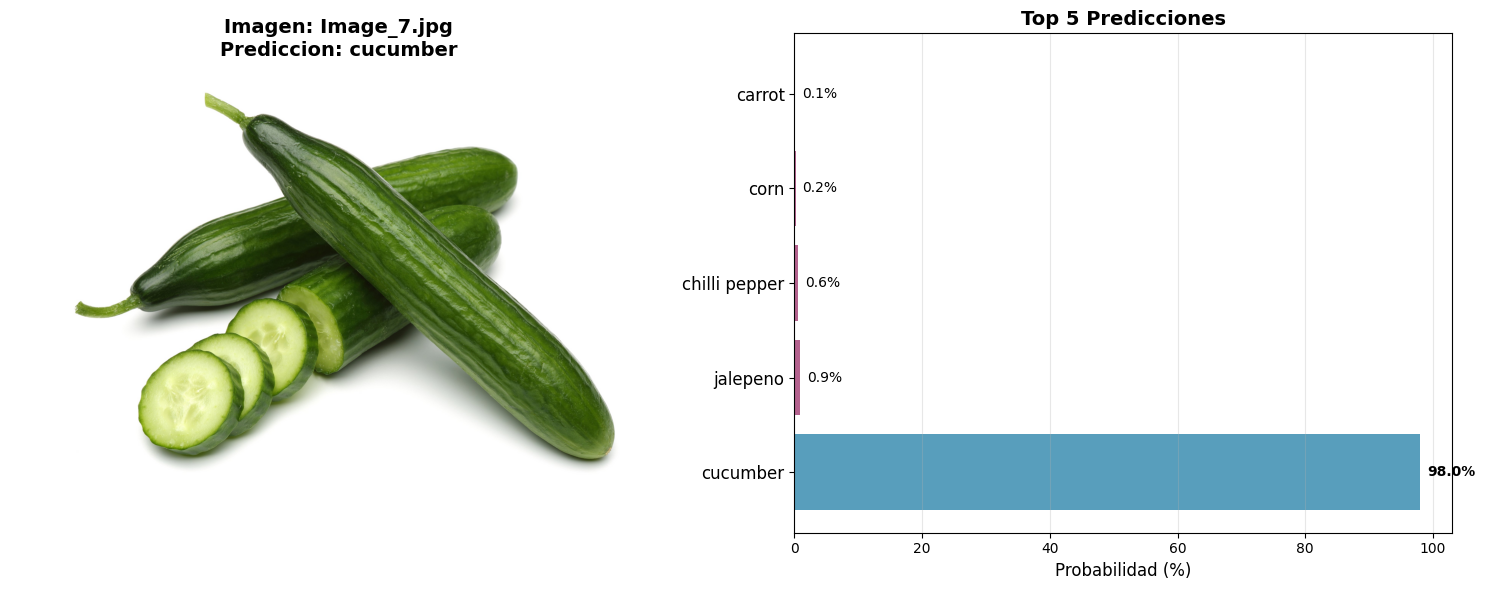


PREDICCION PARA: Image_7.jpg
 1. cucumber         98.05% ⭐ PREDICCION PRINCIPAL
 2. jalepeno          0.94% 
 3. chilli pepper     0.63% 
 4. corn              0.23% 
 5. carrot            0.15% 

========================= IMAGEN 3/3 =========================
Clase real: jalepeno
Prediccion: jalepeno (Confianza: 82.66%)
Resultado: ✅ CORRECTA


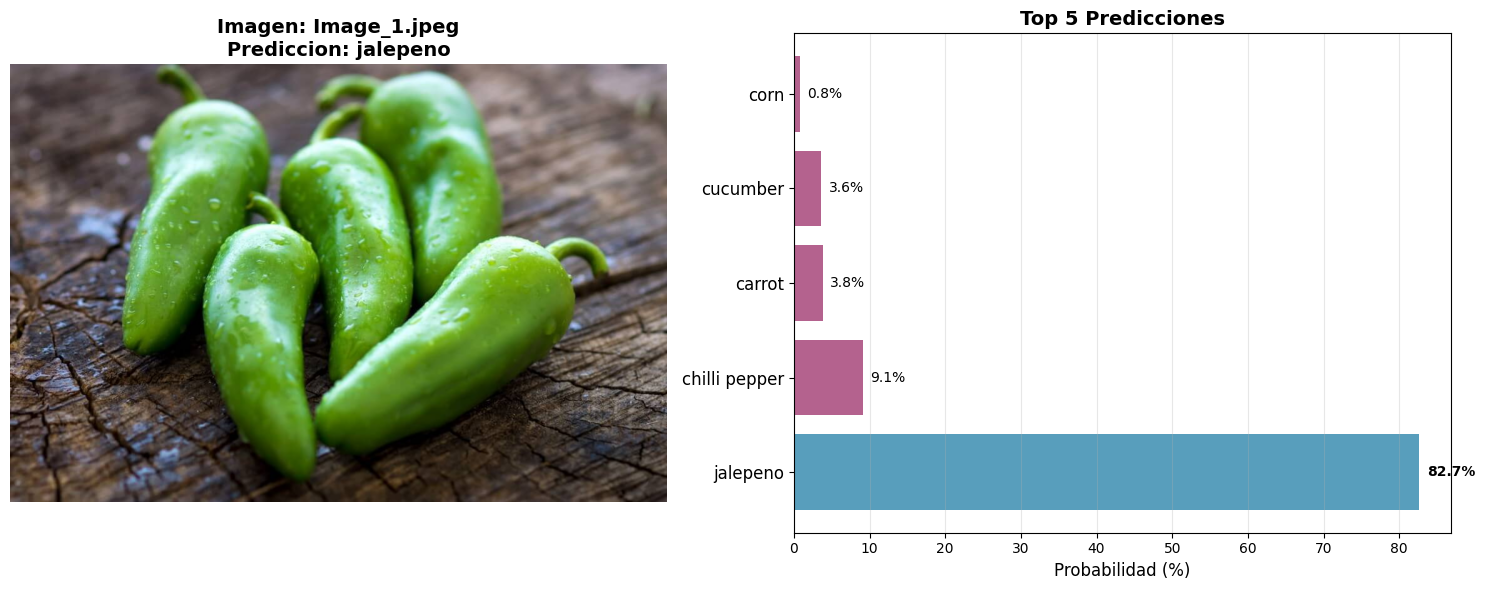


PREDICCION PARA: Image_1.jpeg
 1. jalepeno         82.66% ⭐ PREDICCION PRINCIPAL
 2. chilli pepper     9.12% 
 3. carrot            3.83% 
 4. cucumber          3.63% 
 5. corn              0.76% 


In [39]:
# OPCION 1: Prediccion de imagenes aleatorias del conjunto de test
print("\n🎲 OPCION 1: Predicciones en imagenes aleatorias del conjunto de test")
print("-"*70)

test_dataset_path = f"{data_dir}/test"
num_test_samples = 3  # Puedes cambiar este numero

predict_random_from_test(
    model=trained_model,
    test_dataset_path=test_dataset_path,
    class_names=class_names,
    transform=val_test_transform,
    device=device,
    num_samples=num_test_samples
)

In [40]:
print("\n📁 OPCION 3: Selector interactivo de imagenes")
print("-"*70)
print("Usa el widget de abajo para seleccionar una imagen de tu computadora")

try:
    import ipywidgets as widgets
    from IPython.display import display
    import io
    
    # Crear widget de subida de archivos
    upload_widget = widgets.FileUpload(
        accept='.jpg,.jpeg,.png,.bmp,.tiff',
        multiple=False,
        description='📁 Seleccionar imagen'
    )
    
    output_widget = widgets.Output()
    
    def predict_from_widget(change):
        """
        Funcion que se ejecuta cuando se selecciona una imagen
        """
        output_widget.clear_output()
        
        if not upload_widget.value:
            return
        
        with output_widget:
            try:
                # Obtener archivo subido (compatible con diferentes versiones de ipywidgets)
                try:
                    # Para ipywidgets < 8.0
                    file_info = next(iter(upload_widget.value.values()))
                    file_bytes = file_info['content']
                    filename = file_info['name']
                except (AttributeError, TypeError):
                    # Para ipywidgets >= 8.0
                    if isinstance(upload_widget.value, tuple) and len(upload_widget.value) > 0:
                        file_info = upload_widget.value[0]
                        file_bytes = file_info['content']
                        filename = file_info['name']
                    elif hasattr(upload_widget.value, 'values') and upload_widget.value.values():
                        file_info = list(upload_widget.value.values())[0]
                        file_bytes = file_info['content']
                        filename = file_info['name']
                    else:
                        print("❌ No se pudo obtener la imagen subida")
                        return
                
                # Si 'content' es memoryview, convertir a bytes
                if isinstance(file_bytes, memoryview):
                    file_bytes = file_bytes.tobytes()
                
                print(f"🔍 Analizando imagen: {filename}")
                print("-" * 50)
                
                # Cargar imagen desde bytes
                image = Image.open(io.BytesIO(file_bytes)).convert('RGB')
                original_image = image.copy()
                
                # Aplicar transformaciones
                input_tensor = val_test_transform(image).unsqueeze(0).to(device)
                
                # Realizar prediccion
                trained_model.eval()
                with torch.no_grad():
                    outputs = trained_model(input_tensor)
                    probabilities = F.softmax(outputs, dim=1)
                    
                    # Obtener todas las probabilidades
                    probs = probabilities.cpu().numpy()[0]
                    
                    # Crear lista de predicciones ordenadas
                    predictions = [(class_names[i], prob * 100) for i, prob in enumerate(probs)]
                    predictions.sort(key=lambda x: x[1], reverse=True)
                    
                    # Clase con mayor probabilidad
                    predicted_class = predictions[0][0]
                    confidence = predictions[0][1]
                
                print(f"✅ Prediccion completada!")
                print(f"Clase predicha: {predicted_class}")
                print(f"Confianza: {confidence:.2f}%")
                
                # Mostrar visualizacion
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
                
                # Mostrar imagen original
                ax1.imshow(original_image)
                ax1.set_title(f'Imagen: {filename}\nPrediccion: {predicted_class}', 
                              fontsize=14, fontweight='bold')
                ax1.axis('off')
                
                # Mostrar grafico de barras con probabilidades
                top_predictions = predictions[:len(class_names)]
                classes = [pred[0] for pred in top_predictions]
                probs_display = [pred[1] for pred in top_predictions]
                
                # Colores para las barras
                colors = ['#2E86AB' if i == 0 else '#A23B72' for i in range(len(classes))]
                
                bars = ax2.barh(range(len(classes)), probs_display, color=colors, alpha=0.8)
                ax2.set_yticks(range(len(classes)))
                ax2.set_yticklabels(classes, fontsize=12)
                ax2.set_xlabel('Probabilidad (%)', fontsize=12)
                ax2.set_title('Predicciones por Clase', fontsize=14, fontweight='bold')
                ax2.grid(axis='x', alpha=0.3)
                
                # Agregar valores en las barras
                for i, (bar, prob) in enumerate(zip(bars, probs_display)):
                    ax2.text(prob + 1, bar.get_y() + bar.get_height()/2, 
                            f'{prob:.1f}%', va='center', ha='left',
                            fontweight='bold' if i == 0 else 'normal')
                
                plt.tight_layout()
                plt.show()
                
                # Imprimir resumen detallado
                print("\n" + "="*60)
                print(f"RESUMEN DE PREDICCION PARA: {filename}")
                print("="*60)
                
                for i, (class_name, probability) in enumerate(predictions):
                    status = "⭐ PREDICCION PRINCIPAL" if i == 0 else ""
                    print(f"{i+1:2d}. {class_name:<15} {probability:6.2f}% {status}")
                
                print("="*60)
                print("✅ Analisis completado exitosamente!")
                
            except Exception as e:
                print(f"❌ Error al procesar la imagen: {e}")
                print("Verifica que el archivo sea una imagen valida (JPG, PNG, etc.)")
    
    # Conectar la funcion al widget
    upload_widget.observe(predict_from_widget, names='value')
    
    # Mostrar widgets
    print("📋 Instrucciones:")
    print("1. Haz clic en 'Seleccionar imagen' abajo")
    print("2. Selecciona una imagen desde tu computadora")
    print("3. La prediccion se mostrara automaticamente")
    print("\nFormatos soportados: JPG, JPEG, PNG, BMP, TIFF")
    
    display(upload_widget)
    display(output_widget)
    
except ImportError:
    print("❌ ipywidgets no esta instalado.")
    print("Para usar esta funcionalidad, instala ipywidgets:")
    print("pip install ipywidgets")
    print("\nO usa las opciones 1 y 2 de arriba para predicciones sin widgets.")


📁 OPCION 3: Selector interactivo de imagenes
----------------------------------------------------------------------
Usa el widget de abajo para seleccionar una imagen de tu computadora
📋 Instrucciones:
1. Haz clic en 'Seleccionar imagen' abajo
2. Selecciona una imagen desde tu computadora
3. La prediccion se mostrara automaticamente

Formatos soportados: JPG, JPEG, PNG, BMP, TIFF


FileUpload(value=(), accept='.jpg,.jpeg,.png,.bmp,.tiff', description='📁 Seleccionar imagen')

Output()